In [9]:
import Traj_Analyzer as TA

In [6]:
basepath = '/Users/shijizhao/Documents/Lab_Luo/ActKR/Joel/tetpnop/'

In [12]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

sns.set(font_scale=2) 
sns.set_style("ticks")

In [68]:
def energySample(basepath, subpath, csv_name, sim_list, col_list, text, subtract=False, sampling=False, n_size=1):
    '''
    Sample the data points of MMPBSA, and save sampled points to a .csv file
    
    Parameters
    ----------
    basepath : str
        The basepath of source file
    
    subpath : str
        The subpath of source file (.csv file generated by MMPBSA run)
    
    csv_name : str
        The path to the output file (.csv)
    
    sim_list : int[]
        The list of trajectory indices t be analyzed (based on score)

    col_list : str[]
        The list of columes to be analyzed ('DELTA TOTAL', 'VDWAALS', 'EEL', 'ENPOLAR', 'EPB')
    
    text : str
        The text to be printed ("Total Energy", "Packing/Hydrophobic Effect", etc)
    
    subtract : boolean
        If False, just save target data indicated by col; If True, subtract col from Delta Total
    
    sampling : boolean
        If False, do not do sampling; If True, sample from datasets with size indicated by n_size
        
    n_size : int
        Sample size in each trajectory
    
    '''
    sim_all = pd.DataFrame()                  # Dataframe for raw energy data
    
    for i in sim_list:
        sim = pd.read_csv(basepath+subpath%(i,i), skiprows=464)

        cavg = pd.DataFrame()                 # Dataframe of cumulative average of all data points from col
        sim_equil = pd.DataFrame()            # Dataframe for equilibrated data points from col
        for col in col_list:
            cavg_col = sim[col].expanding().mean().to_frame(name = text)
            sim_equil_col = sim[col].iloc[51:151].to_frame(name = text)
            cavg = cavg.add(cavg_col, fill_value = 0.0)
            sim_equil = sim_equil.add(sim_equil_col, fill_value = 0.0)

        if subtract == False:
            print('The cumulative average '+text+' of sim %s'%(i),cavg.iloc[150])
            if sampling == False:
                sim_sample = sim_equil
            else:
                sim_sample = sim_equil.sample(n=n_size, replace = False) # Random sample from equilibrated data points (Order rearranged)        
        else:
            print('%s subtracted from Total Energy'%(text))
            sim_subtract = sim['DELTA TOTAL'].iloc[51:151].to_frame(name = text).subtract(sim_equil) # Dataframe for subtracted data points
            if sampling == False:
                sim_sample = sim_subtract
            else:
                sim_sample = sim_subtract.sample(n=n_size, replace = False) # Random sample from subtracted data points (Order rearranged)

        sim_all=sim_all.append(sim_sample, ignore_index=True)

    if subtract == False:
        sim_all.to_csv(csv_name, index=False)
    else:
        sim_all.to_csv(csv_name, index=False, header=['sub-%s'%(text)]) # Save sampled data points to csv_name

In [69]:
sim_list = [1]

subpath = 'tetpnop_ActKR_MMPBSA_joel%s/ActKR_1_tetpnop_joel%s_energy_indi.csv'
csv_name = '/Users/shijizhao/Desktop/ActKR-tetpnop-joel-total.csv'
col_list = ['DELTA TOTAL']
text = "Total Energy"
energySample(basepath, subpath, csv_name, sim_list, col_list, text)

subpath = 'tetpnop_ActKR_MMPBSA_joel%s/ActKR_1_tetpnop_joel%s_energy_indi.csv'
csv_name = '/Users/shijizhao/Desktop/ActKR-tetpnop-joel-vdw.csv'
col_list = ['VDWAALS', 'ENPOLAR']
text = "Packing/Hydrophobic Effect"
energySample(basepath, subpath, csv_name, sim_list, col_list, text)

subpath = 'tetpnop_ActKR_MMPBSA_joel%s/ActKR_1_tetpnop_joel%s_energy_indi.csv'
csv_name = '/Users/shijizhao/Desktop/ActKR-tetpnop-joel-ele.csv'
col_list = ['EEL', 'EPB']
text = "Electrostatic Effect"
energySample(basepath, subpath, csv_name, sim_list, col_list, text)

The cumulative average Total Energy of sim 1 Total Energy   -51.314842
Name: 150, dtype: float64
The cumulative average Packing/Hydrophobic Effect of sim 1 Packing/Hydrophobic Effect   -56.015283
Name: 150, dtype: float64
The cumulative average Electrostatic Effect of sim 1 Electrostatic Effect    4.700442
Name: 150, dtype: float64


In [70]:
def energyPlot(basepath, subpath, col_list, title_name, y_label, fig_name):
    '''
    Plot the energy change of each trajectory, including individual data points and cumulative 
    average data points, and save the plot as a .png file
    
    Parameters
    ----------
    basepath : str
        The basepath of source file
    
    subpath : str
        The subpath of source file (.csv file generated by MMPBSA run)
    
    col_list : str[]
        The list of columes to be analyzed ('DELTA TOTAL', 'VDWAALS', 'EEL', 'ENPOLAR', 'EPB')
    
    title_name : str
        The title of the figure

    y_label : str
        The label of y axes

    fig_name : str
        The path to the output file (.png)
    
    '''
    plt.figure(figsize=(24, 8),dpi=150)
    color_list = ['dum','r','g','b']
    for i in range(1, 4):
        sim = pd.read_csv(basepath+subpath%(i,i),skiprows=464)
        
        cavg = pd.DataFrame()              # Dataframe of cumulative average data points
        sim_total = pd.DataFrame()         # Dataframe of individual data points
        for col in col_list:
            sim_col = sim[col].to_frame(name = 'a')                          
            cavg_col = sim[col].expanding().mean().to_frame(name = 'a')
            sim_total = sim_total.add(sim_col, fill_value = 0.0)
            cavg = cavg.add(cavg_col, fill_value = 0.0)
        
        # PLOT 
        plt.plot(np.array(range(len(cavg)))+50,cavg,label='Sim %s'%i,color=color_list[i],linewidth=2)
        plt.plot(np.array(range(len(sim_total)))+50,sim_total,'.',label='Sim %s'%i,color=color_list[i])
        
        # LEGEND & TITLE & ETC. 
        plt.legend()
        plt.title(title_name)
        plt.ylabel(y_label)
        plt.xlabel('Time (ns)')
    
    plt.savefig(fig_name,bbox_inches='tight',transparent=True)

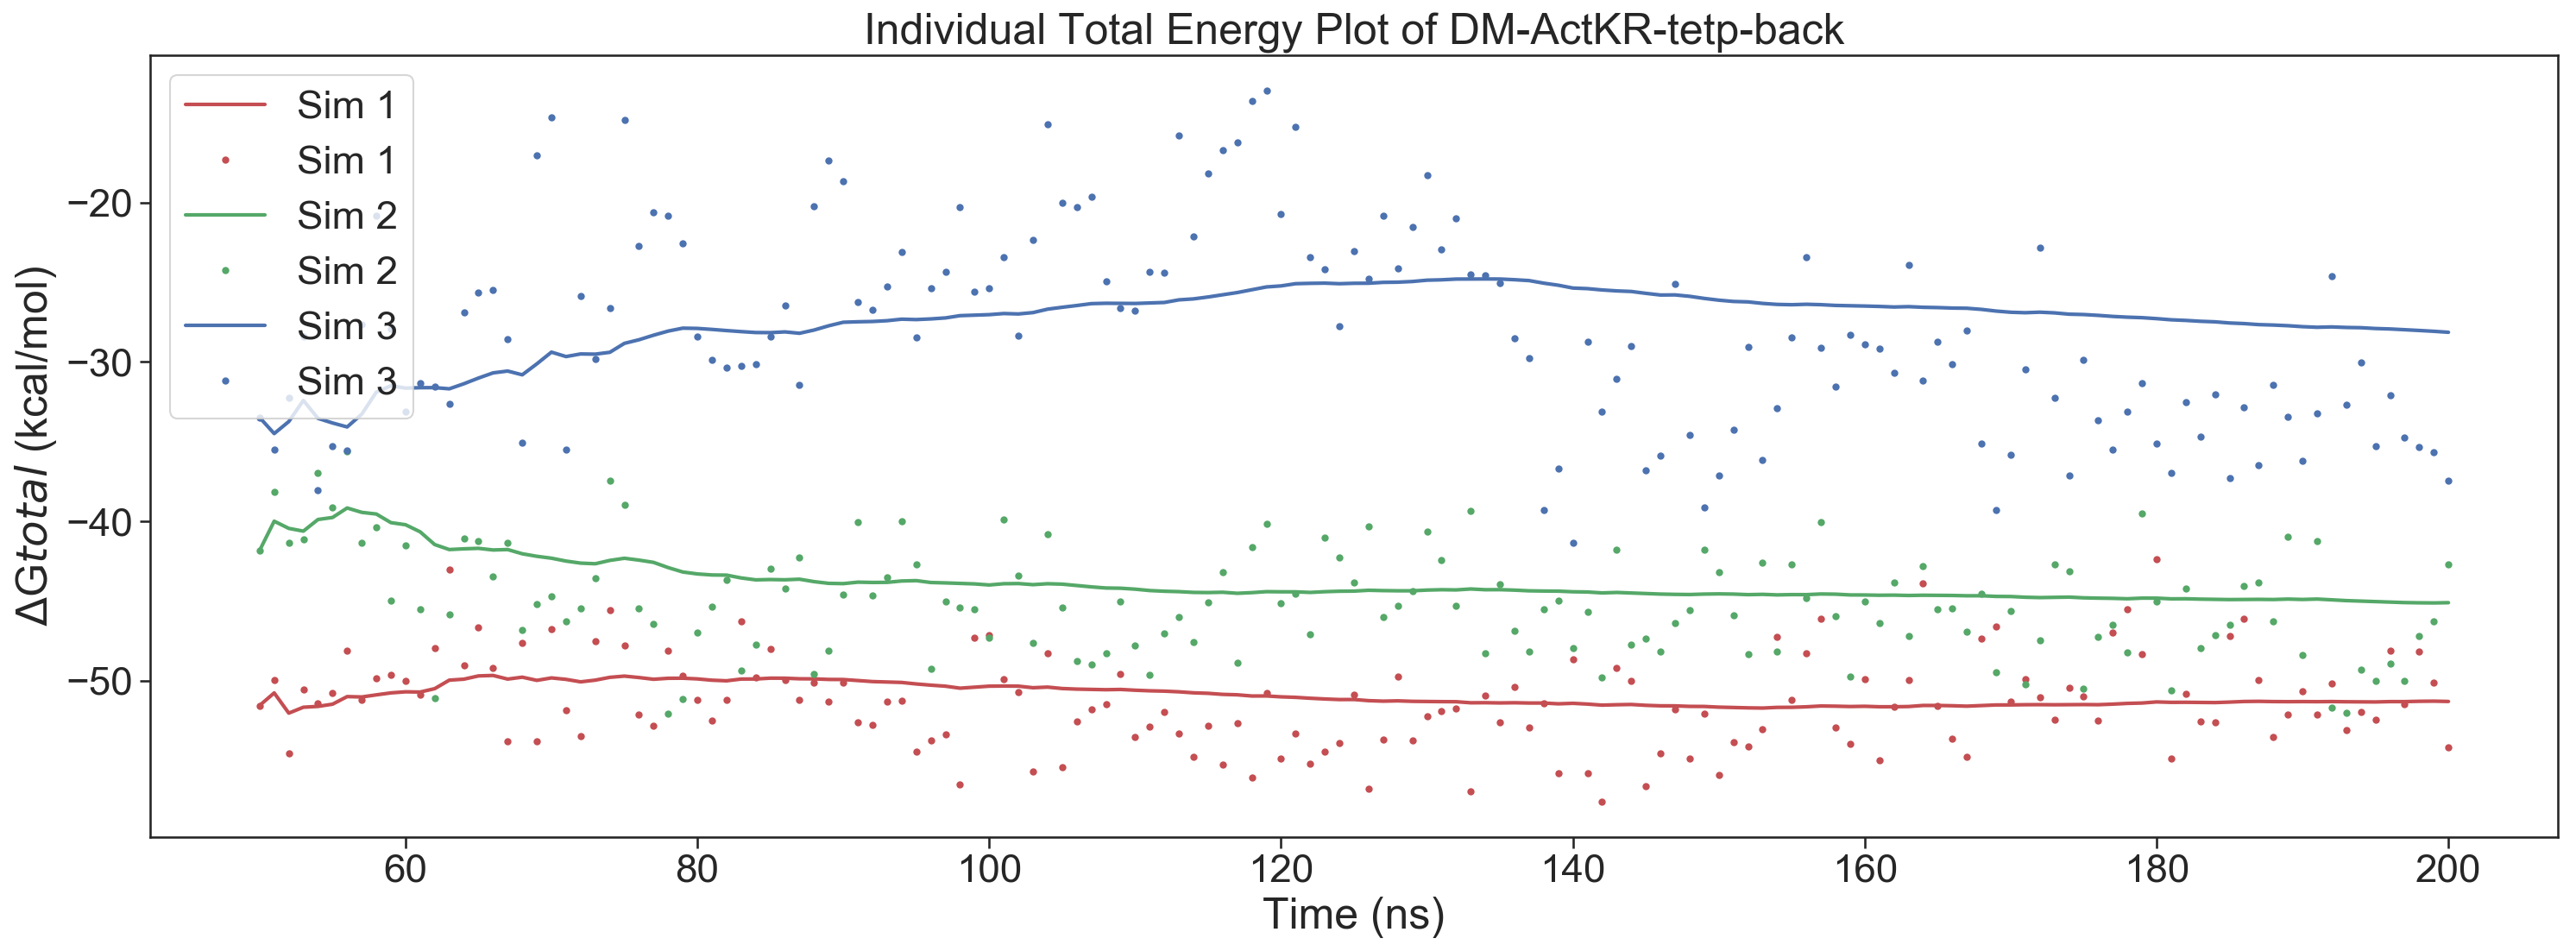

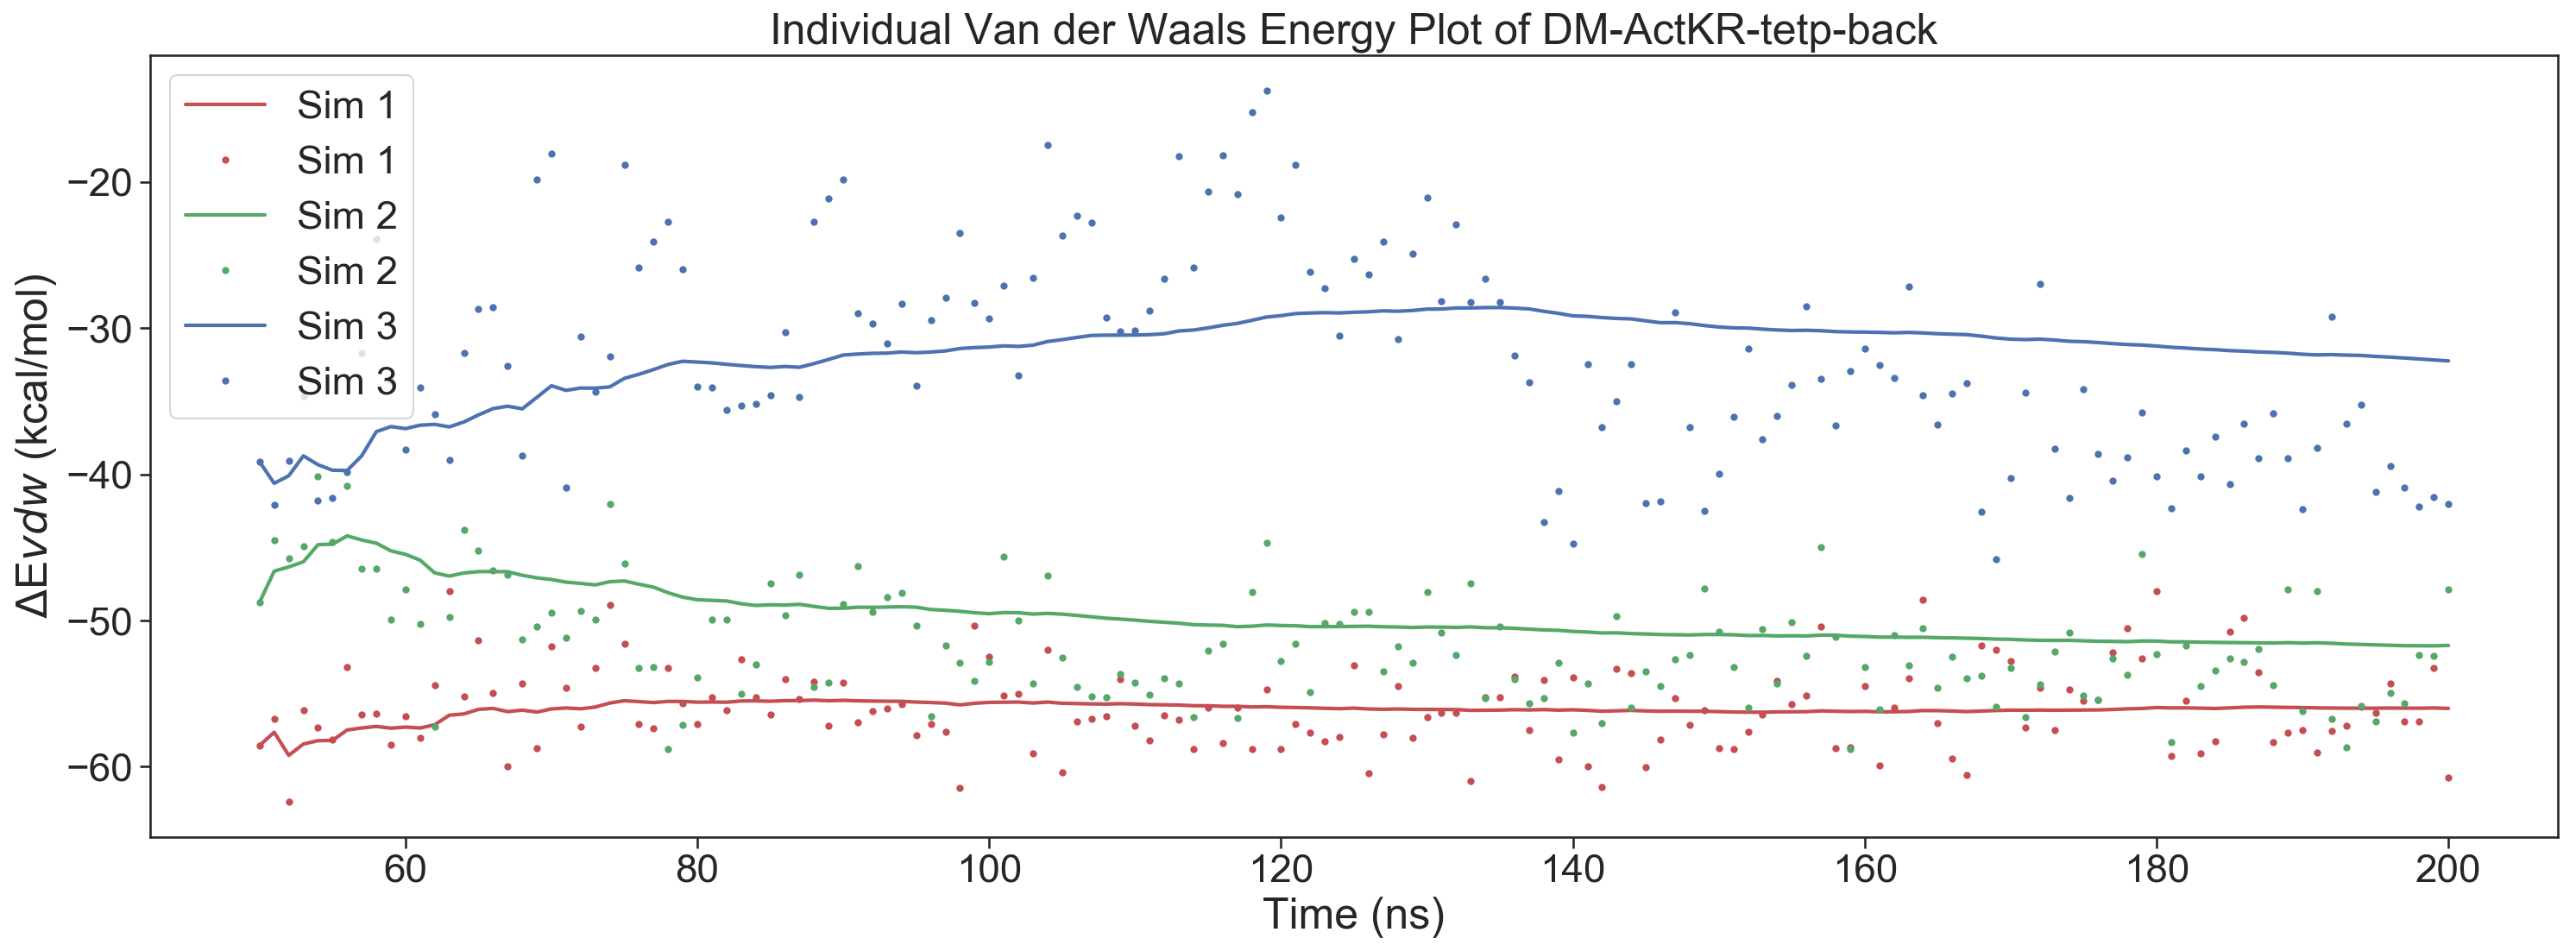

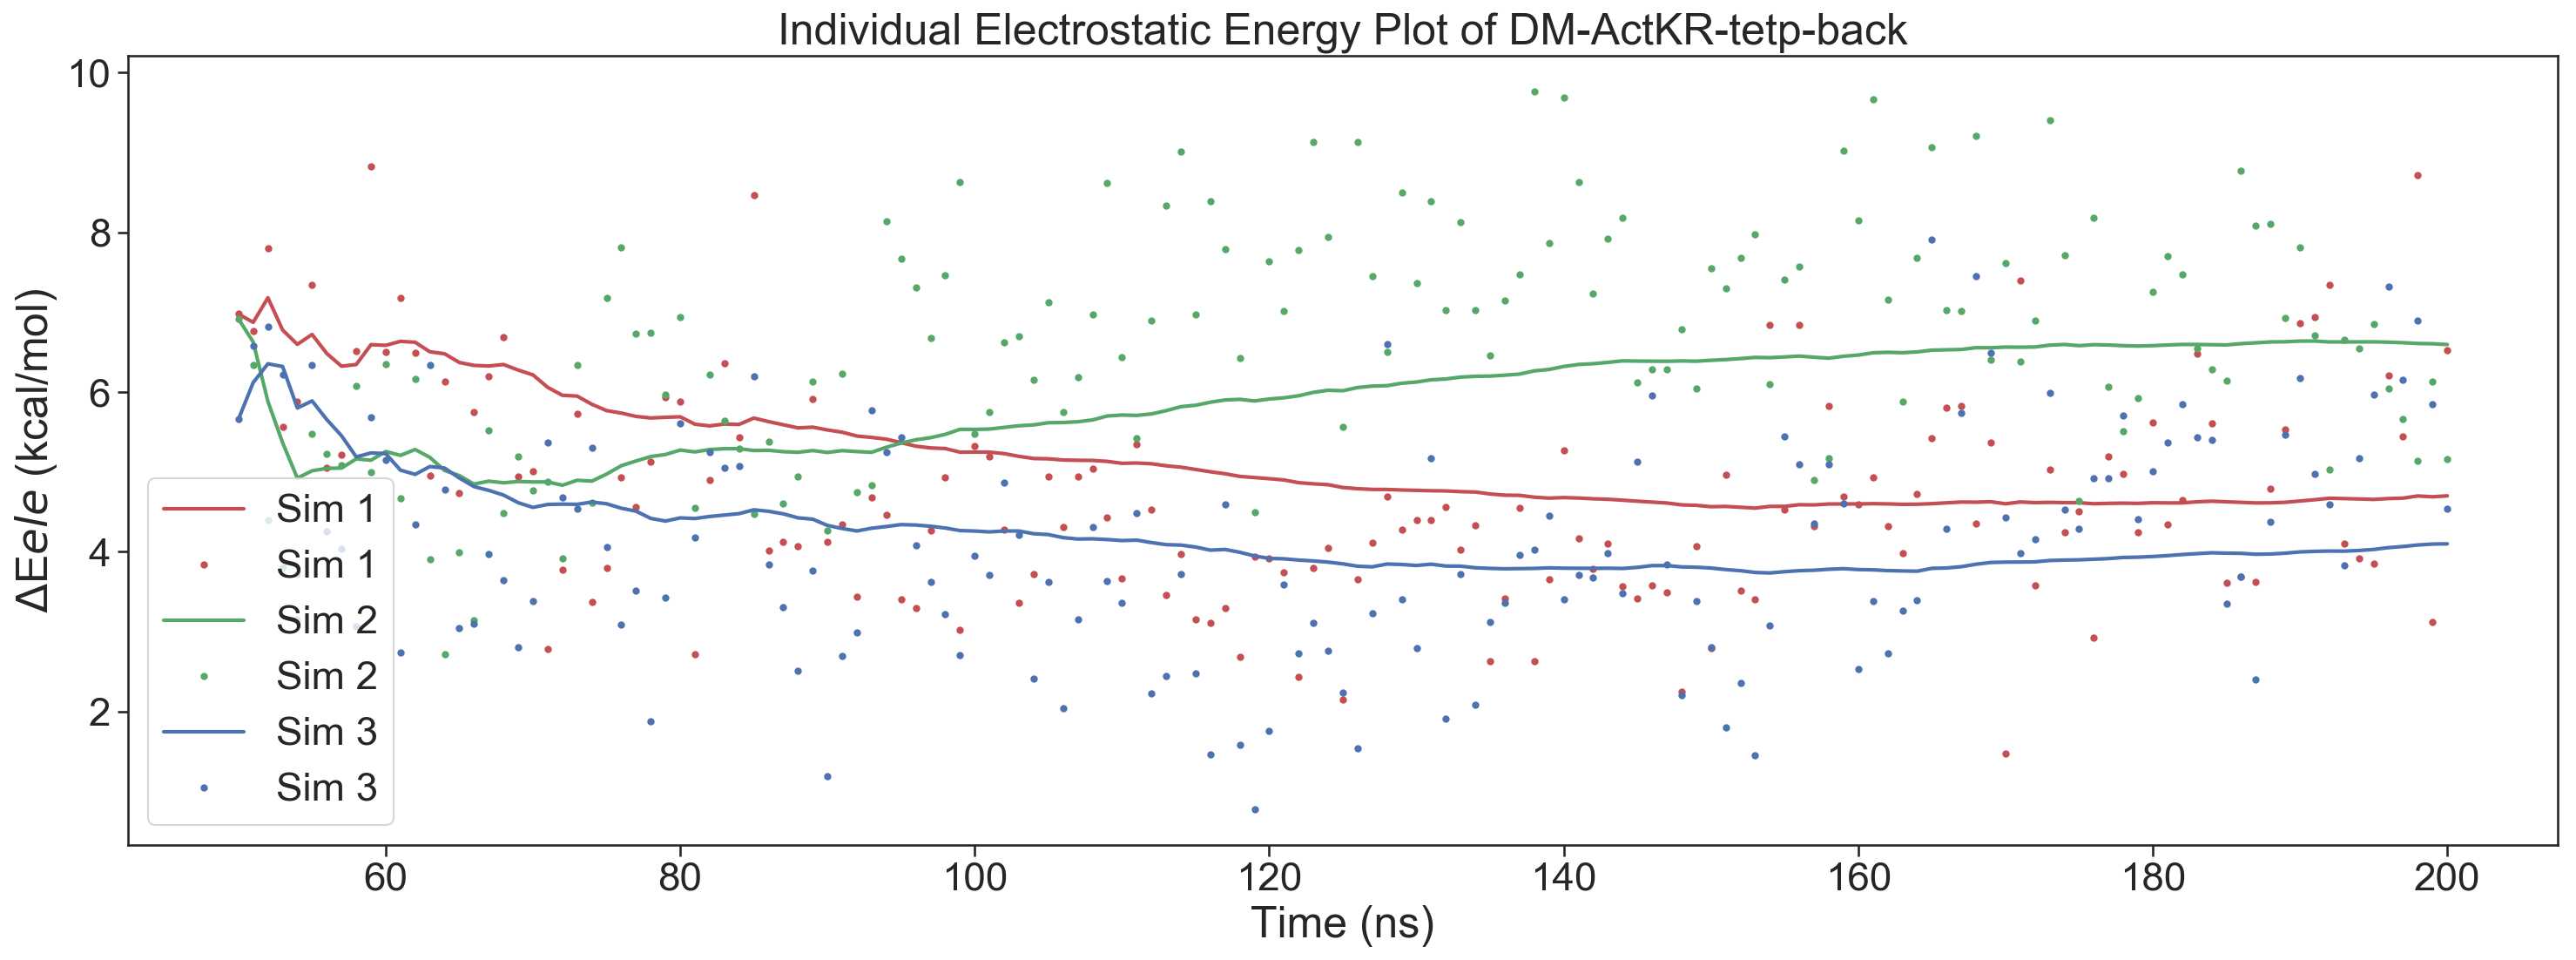

In [74]:
subpath = 'tetpnop_ActKR_MMPBSA_joel%s/ActKR_1_tetpnop_joel%s_energy_indi.csv'
col_list = ['DELTA TOTAL']
title_name = 'Individual Total Energy Plot of DM-ActKR-tetp-back'
fig_name = '/Users/shijizhao/Desktop/DM-ActKR-tetp-back-total'
y_label = '$\Delta$G${total}$ (kcal/mol)'
energyPlot(basepath, subpath, col_list, title_name, y_label, fig_name)

subpath = 'tetpnop_ActKR_MMPBSA_joel%s/ActKR_1_tetpnop_joel%s_energy_indi.csv'
col_list = ['VDWAALS', 'ENPOLAR']
title_name = 'Individual Van der Waals Energy Plot of DM-ActKR-tetp-back'
fig_name = '/Users/shijizhao/Desktop/DM-ActKR-tetp-back-vdw'
y_label = '$\Delta$E${vdw}$ (kcal/mol)'
energyPlot(basepath, subpath, col_list, title_name, y_label, fig_name)

subpath = 'tetpnop_ActKR_MMPBSA_joel%s/ActKR_1_tetpnop_joel%s_energy_indi.csv'
col_list = ['EEL', 'EPB']
title_name = 'Individual Electrostatic Energy Plot of DM-ActKR-tetp-back'
fig_name = '/Users/shijizhao/Desktop/DM-ActKR-tetp-back-ele'
y_label = '$\Delta$E${ele}$ (kcal/mol)'
energyPlot(basepath, subpath, col_list, title_name, y_label, fig_name)